In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

In [2]:
# data = []
# for i in range(1, 11):
#     new = pd.read_csv(f'../simulator/data/data({i}).csv')
#     data.append(new)

# df = pd.concat(data).reset_index(drop=True).drop(columns='Unnamed: 0')
# df.to_csv('../simulator/data/data.csv', index=False)
# df

In [3]:
df = pd.read_csv('../simulator/data/data.csv')

In [31]:
df.head()

,predator_radius,predator_pos_x,predator_pos_y,predator_vel_x,predator_vel_y,prey_radius,prey_pos_x,prey_pos_y,prey_vel_x,prey_vel_y,prey_survived
0,13.22173,719.484482,4.25762,-52.370282,-236.952714,35.799887,837.318845,410.356158,-216.426000,164.810235,0.0
1,13.22173,719.484482,4.25762,-52.370282,-236.952714,16.721659,448.866083,268.230650,-159.617011,145.201106,0.0
2,13.22173,719.484482,4.25762,-52.370282,-236.952714,31.893409,50.798808,35.758662,-233.724551,285.828792,0.0
3,13.22173,719.484482,4.25762,-52.370282,-236.952714,35.797240,712.087834,465.818909,-274.712776,165.414043,0.0
4,13.22173,719.484482,4.25762,-52.370282,-236.952714,20.677660,121.425868,773.583944,214.195694,-135.398988,1.0


In [39]:
def remove_trivial(X):
    condition = ((X['predator_pos_x']-X['prey_pos_x'])**2 + (X['predator_pos_y']-X['prey_pos_y'])**2
                 >
                 (X['predator_radius']+X['prey_radius'])**2)
    return X[condition]

In [40]:
df = remove_trivial(df)

In [6]:
train, test = train_test_split(df, train_size=0.6)
train, val = train_test_split(train, train_size=0.8)

target = 'prey_survived'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(47556, 10) (47556,) (11890, 10) (11890,) (39631, 10) (39631,)


In [7]:
y_train.value_counts()

0.0    29095
1.0    18461
Name: prey_survived, dtype: int64

In [8]:
class Poly:
    def __init__(self, degree):
        self.degree = degree
    
    def fit(self, X):
        self.columns = X.columns
        
    def transform(self, X):
        df = X.copy()
        for col in self.columns:
            for n in range(2, self.degree+1):
                df[f'{col}^{n}'] = df[col]**n
        return df
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [9]:
Poly(5).fit_transform(X_train)

,predator_radius,predator_pos_x,predator_pos_y,predator_vel_x,predator_vel_y,prey_radius,prey_pos_x,prey_pos_y,prey_vel_x,prey_vel_y,...,prey_pos_y^4,prey_pos_y^5,prey_vel_x^2,prey_vel_x^3,prey_vel_x^4,prey_vel_x^5,prey_vel_y^2,prey_vel_y^3,prey_vel_y^4,prey_vel_y^5
23177,34.412293,662.484132,303.819950,-46.465678,73.411893,39.906477,124.018239,164.920914,-263.286309,102.275594,...,7.397806e+08,1.220053e+11,69319.680352,-1.825092e+07,4.805218e+09,-1.265148e+12,10460.297127,1.069833e+06,1.094178e+08,1.119077e+10
99810,10.666808,468.953911,176.527339,227.335167,-170.831742,36.703657,195.214464,571.756699,-131.180244,-39.379096,...,1.068674e+11,6.110212e+13,17208.256515,-2.257383e+06,2.961241e+08,-3.884563e+10,1550.713220,-6.106569e+04,2.404711e+06,-9.469537e+07
860,17.437325,825.040568,670.098567,-221.084114,-47.190467,22.785379,522.647067,145.673515,-85.651916,-261.733833,...,4.503212e+08,6.559987e+10,7336.250708,-6.283639e+05,5.382057e+07,-4.609835e+09,68504.599228,-1.792997e+07,4.692880e+09,-1.228285e+12
51130,23.867557,264.947154,392.107945,266.148051,211.151822,7.008446,920.173891,561.983971,-276.651177,66.632109,...,9.974605e+10,5.605568e+13,76535.873984,-2.117374e+07,5.857740e+09,-1.620551e+12,4439.837998,2.958358e+05,1.971216e+07,1.313463e+09
1140,13.263107,244.777992,827.292743,-264.145492,91.649026,30.479196,853.446049,412.125929,-201.022959,265.694231,...,2.884827e+10,1.188912e+13,40410.230200,-8.123384e+06,1.632987e+09,-3.282678e+11,70593.424606,1.875627e+07,4.983432e+09,1.324069e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7962,39.183802,22.401034,649.584133,274.721745,-272.531319,28.265448,634.666314,129.794456,-167.194880,159.348260,...,2.838080e+08,3.683670e+10,27954.127825,-4.673787e+06,7.814333e+08,-1.306516e+11,25391.867957,4.046150e+06,6.447470e+08,1.027393e+11
12123,16.539152,106.175265,522.057718,-173.912529,-245.430758,7.437079,222.319207,436.604668,152.753351,-132.327448,...,3.633737e+10,1.586507e+13,23333.586091,3.564283e+06,5.444562e+08,8.316751e+10,17510.553402,-2.317127e+06,3.066195e+08,-4.057417e+10
32765,11.851633,825.150251,397.139041,151.396343,125.687628,17.737822,648.540052,790.009897,-293.401053,46.060591,...,3.895203e+11,3.077249e+14,86084.178026,-2.525719e+07,7.410486e+09,-2.174244e+12,2121.578005,9.772114e+04,4.501093e+06,2.073230e+08
60120,39.649023,474.329012,135.856419,-111.240855,-183.421199,39.803169,382.475590,783.623773,259.731183,-161.991818,...,3.770773e+11,2.954868e+14,67460.287177,1.752154e+07,4.550890e+09,1.182008e+12,26241.349061,-4.250884e+06,6.886084e+08,-1.115489e+11


In [10]:
def preprocess(X, degree=2):
    df = X.copy()
    
    # scaling
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    # power
    if degree >= 2:
        poly = Poly(degree)
        df = poly.fit_transform(df)
    
    return df

In [11]:
preprocess(X_train, 5).describe()

,predator_radius,predator_pos_x,predator_pos_y,predator_vel_x,predator_vel_y,prey_radius,prey_pos_x,prey_pos_y,prey_vel_x,prey_vel_y,...,prey_pos_y^4,prey_pos_y^5,prey_vel_x^2,prey_vel_x^3,prey_vel_x^4,prey_vel_x^5,prey_vel_y^2,prey_vel_y^3,prey_vel_y^4,prey_vel_y^5
count,4.755600e+04,4.755600e+04,4.755600e+04,4.755600e+04,4.755600e+04,4.755600e+04,4.755600e+04,4.755600e+04,4.755600e+04,4.755600e+04,...,4.755600e+04,4.755600e+04,47556.000000,47556.000000,47556.000000,47556.000000,47556.000000,47556.000000,47556.000000,47556.000000
mean,5.070990e-16,-4.261995e-16,1.009300e-16,-3.594288e-17,1.368986e-17,1.439769e-16,-1.326240e-16,2.737774e-17,-3.104439e-17,4.664449e-18,...,1.826831e+00,6.604584e-02,1.000000,0.017725,1.605059,0.059234,1.000000,-0.000830,1.622973,-0.001272
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,...,2.517776e+00,4.972946e+00,0.777864,1.748040,1.938819,3.717599,0.789295,1.770425,1.989240,3.818051
min,-1.734810e+00,-1.728482e+00,-1.743150e+00,-1.653460e+00,-1.618255e+00,-1.729138e+00,-1.785248e+00,-1.771270e+00,-1.623025e+00,-1.647018e+00,...,7.111277e-22,-1.743507e+01,0.023122,-4.275393,0.000535,-11.262289,0.026458,-4.467817,0.000700,-12.119713
25%,-8.736500e-01,-8.568733e-01,-8.692197e-01,-9.149572e-01,-9.002541e-01,-8.632947e-01,-8.609631e-01,-8.613259e-01,-9.119923e-01,-9.044323e-01,...,3.377730e-02,-4.740647e-01,0.292308,-0.758531,0.085444,-0.630893,0.287645,-0.739824,0.082740,-0.605174
50%,-7.798297e-03,-2.744722e-03,-6.593313e-03,1.745715e-01,-1.667445e-01,-3.161067e-03,-1.107168e-03,-8.283891e-03,-1.731539e-01,1.646653e-01,...,5.438618e-01,-3.900978e-11,0.839689,-0.005192,0.705077,-0.000156,0.816355,0.004465,0.666435,0.000121
75%,8.738273e-01,8.574137e-01,8.654392e-01,9.016921e-01,9.165326e-01,8.680919e-01,8.624308e-01,8.555274e-01,9.195661e-01,9.027570e-01,...,2.801231e+00,4.583208e-01,1.616591,0.777587,2.613365,0.657529,1.627346,0.735720,2.648254,0.599590
max,1.728475e+00,1.860211e+00,1.836793e+00,1.611316e+00,1.656975e+00,1.738953e+00,1.884365e+00,1.898456e+00,1.645871e+00,1.643153e+00,...,1.298980e+01,2.466057e+01,2.708890,4.458483,7.338085,12.077539,2.712670,4.436435,7.358578,11.978162


In [12]:
poly_data = {}
for n in range(2, 6):
    poly_data[n] = {
        'X_train': preprocess(X_train, n),
        'X_val': preprocess(X_val, n),
        'X_test': preprocess(X_test, n)
    }

In [13]:
for n in range(2, 6):
    model = LogisticRegression(class_weight='balanced', max_iter=1000000)

    model.fit(poly_data[n]['X_train'], y_train)
    coef = model.coef_[0]
    
    print('n =', n)
    print('predator_radius', coef[[10*i for i in range(n)]])
    print('predator_pos_x', coef[[10*i+1 for i in range(n)]])
    print('predator_pos_y', coef[[10*i+2 for i in range(n)]])
    print('predator_vel_x', coef[[10*i+3 for i in range(n)]])
    print('predator_vel_y', coef[[10*i+4 for i in range(n)]])
    print('prey_radius', coef[[10*i+5 for i in range(n)]])
    print('prey_pos_x', coef[[10*i+6 for i in range(n)]])
    print('prey_pos_y', coef[[10*i+7 for i in range(n)]])
    print('prey_vel_x', coef[[10*i+8 for i in range(n)]])
    print('prey_vel_y', coef[[10*i+9 for i in range(n)]])
    print('훈련 f1', f1_score(model.predict(poly_data[n]['X_train']), y_train),
          accuracy_score(model.predict(poly_data[n]['X_train']), y_train))
    print('검증 f1', f1_score(model.predict(poly_data[n]['X_val']), y_val),
          accuracy_score(model.predict(poly_data[n]['X_val']), y_val))
    print()

n = 2
predator_radius [-0.4336376   0.02775614]
predator_pos_x [-0.00433356  0.00544971]
predator_pos_y [-0.01460202  0.01706106]
predator_vel_x [-0.01237017 -0.20877106]
predator_vel_y [-0.00376818 -0.22659483]
prey_radius [-0.4305568   0.01986511]
prey_pos_x [0.00578705 0.10759942]
prey_pos_y [-0.00228659  0.08832548]
prey_vel_x [ 0.01517438 -0.21601939]
prey_vel_y [-0.01370515 -0.18341324]
훈련 f1 0.5711763407636284 0.6322861468584405
검증 f1 0.5745098039215687 0.6349873843566022

n = 3
predator_radius [-0.43190031  0.02787577  0.0194702 ]
predator_pos_x [-0.00271178 -0.00119823 -0.0246792 ]
predator_pos_y [-0.00551787  0.0054693   0.10748196]
predator_vel_x [-0.05976739 -0.00047272 -0.00864994]
predator_vel_y [-0.01898637  0.0169634   0.08900193]
prey_radius [-0.38793287 -0.00476549 -0.01914198]
prey_pos_x [ 0.02148644 -0.20755227 -0.21567209]
prey_pos_y [0.03294745 0.02963681 0.00877422]
prey_vel_x [ 0.00067813 -0.22768405 -0.18337731]
prey_vel_y [-0.01577232  0.00947946  0.00103473]


In [14]:
model = RandomForestClassifier(max_depth=10, min_samples_leaf=10, class_weight='balanced')

model.fit(X_train, y_train)

print('훈련 f1', f1_score(model.predict(X_train), y_train), accuracy_score(model.predict(X_train), y_train))
print('검증 f1', f1_score(model.predict(X_val), y_val), accuracy_score(model.predict(X_val), y_val))
print()

훈련 f1 0.6228237873110551 0.6888510387753386
검증 f1 0.5691868758915835 0.6444070647603027



In [15]:
model = XGBClassifier(max_depth=3, learning_rate=0.3)

model.fit(X_train, y_train)

print('훈련 f1', f1_score(model.predict(X_train), y_train), accuracy_score(model.predict(X_train), y_train))
print('검증 f1', f1_score(model.predict(X_val), y_val), accuracy_score(model.predict(X_val), y_val))
print()

훈련 f1 0.5038355527513034 0.6858230296913113
검증 f1 0.4772032433869467 0.6692178301093356



In [16]:
def engineering(X):
    df = X.copy()
    df['predator_v'] = np.sqrt(df['predator_vel_x']**2 + df['predator_vel_y']**2)
    df['prey_v'] = np.sqrt(df['prey_vel_x']**2 + df['prey_vel_y']**2)
    df['angle_dif'] = abs(np.arctan(abs(df['predator_vel_y']) / abs(df['predator_vel_x']))
                          - np.arctan(abs(df['prey_vel_y']) / abs(df['prey_vel_x'])))
    
    df['init_dist'] = np.sqrt((df['predator_pos_x']-df['prey_pos_x'])**2 + (df['predator_pos_y']-df['prey_pos_y'])**2)
    
    df = df.drop(columns=['predator_pos_x', 'predator_pos_y', 'prey_pos_x', 'prey_pos_y',
                          'predator_vel_x', 'predator_vel_y', 'prey_vel_x', 'prey_vel_y'])
    
    return df

In [17]:
model = LogisticRegression(class_weight='balanced', max_iter=10000, C=0.1)

X_tr = preprocess(engineering(X_train), 5)
X_va = preprocess(engineering(X_val), 5)

model.fit(X_tr, y_train)

print('훈련')
print('f1', f1_score(model.predict(X_tr), y_train))
print('accuracy', accuracy_score(model.predict(X_tr), y_train))
print('검증')
print('f1', f1_score(model.predict(X_va), y_val))
print('accuracy', accuracy_score(model.predict(X_va), y_val))

훈련
f1 0.5701463988817775
accuracy 0.6314029775422659
검증
f1 0.5776904176904177
accuracy 0.6386038687973087


In [18]:
model = RandomForestClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=20)

X_tr = preprocess(engineering(X_train), 1)
X_va = preprocess(engineering(X_val), 1)

model.fit(X_tr, y_train)

print('훈련')
print('f1', f1_score(model.predict(X_tr), y_train))
print('accuracy', accuracy_score(model.predict(X_tr), y_train))
print('검증')
print('f1', f1_score(model.predict(X_va), y_val))
print('accuracy', accuracy_score(model.predict(X_va), y_val))

훈련
f1 0.5888162817379159
accuracy 0.6533350155606023
검증
f1 0.5725388601036269
accuracy 0.63919259882254


In [19]:
model = XGBClassifier(max_depth=3, learning_rate=0.2)

X_tr = preprocess(engineering(X_train), 2)
X_va = preprocess(engineering(X_val), 2)

model.fit(X_tr, y_train)

print('훈련')
print('f1', f1_score(model.predict(X_tr), y_train))
print('accuracy', accuracy_score(model.predict(X_tr), y_train))
print('검증')
print('f1', f1_score(model.predict(X_va), y_val))
print('accuracy', accuracy_score(model.predict(X_va), y_val))

훈련
f1 0.48708143517440894
accuracy 0.6756455547144419
검증
f1 0.4755726201509334
accuracy 0.6668629100084105


In [20]:
engineering(X_train).describe()

,predator_radius,prey_radius,predator_v,prey_v,angle_dif,init_dist
count,47556.000000,47556.000000,47556.000000,47556.000000,47556.000000,47556.000000
mean,22.531651,22.450421,247.552069,247.024829,0.379823,500.708727
std,10.104076,10.091899,77.785916,76.972094,0.272494,232.202447
min,5.003186,5.000320,45.364711,42.828727,0.000007,20.102038
25%,13.704319,13.738230,193.039994,192.983454,0.156012,319.039102
50%,22.452858,22.418520,256.498251,255.362645,0.331529,491.759088
75%,31.360776,31.211025,303.791789,302.939110,0.556750,674.604556
max,39.996113,39.999572,421.811662,422.068754,1.316582,1309.158871


In [21]:
def eng2(X):
    df = X.copy()
    

In [22]:
X_tr = pd.DataFrame(PolynomialFeatures(2).fit_transform(X_train)).iloc[:, 1:]
X_va = pd.DataFrame(PolynomialFeatures(2).fit_transform(X_val)).iloc[:, 1:]
X_te = pd.DataFrame(PolynomialFeatures(2).fit_transform(X_test)).iloc[:, 1:]

model = LogisticRegression(class_weight='balanced', max_iter=10000, C=0.1)

model.fit(X_tr, y_train)

print('훈련')
print('f1', f1_score(model.predict(X_tr), y_train))
print('accuracy', accuracy_score(model.predict(X_tr), y_train))
print('검증')
print('f1', f1_score(model.predict(X_va), y_val))
print('accuracy', accuracy_score(model.predict(X_va), y_val))

훈련
f1 0.5682984260751023
accuracy 0.6337580957187317
검증
f1 0.5702422145328719
accuracy 0.6343986543313709


In [23]:
X_tr = pd.DataFrame(PolynomialFeatures(2).fit_transform(X_train)).iloc[:, 1:]
X_va = pd.DataFrame(PolynomialFeatures(2).fit_transform(X_val)).iloc[:, 1:]
X_te = pd.DataFrame(PolynomialFeatures(2).fit_transform(X_test)).iloc[:, 1:]

model = RandomForestClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=20)

model.fit(X_tr, y_train)

print('훈련')
print('f1', f1_score(model.predict(X_tr), y_train))
print('accuracy', accuracy_score(model.predict(X_tr), y_train))
print('검증')
print('f1', f1_score(model.predict(X_va), y_val))
print('accuracy', accuracy_score(model.predict(X_va), y_val))

훈련
f1 0.5911604987932422
accuracy 0.6580452519135335
검증
f1 0.5698806059997993
accuracy 0.6394449116904962


In [24]:
X_train

,predator_radius,predator_pos_x,predator_pos_y,predator_vel_x,predator_vel_y,prey_radius,prey_pos_x,prey_pos_y,prey_vel_x,prey_vel_y
23177,34.412293,662.484132,303.819950,-46.465678,73.411893,39.906477,124.018239,164.920914,-263.286309,102.275594
99810,10.666808,468.953911,176.527339,227.335167,-170.831742,36.703657,195.214464,571.756699,-131.180244,-39.379096
860,17.437325,825.040568,670.098567,-221.084114,-47.190467,22.785379,522.647067,145.673515,-85.651916,-261.733833
51130,23.867557,264.947154,392.107945,266.148051,211.151822,7.008446,920.173891,561.983971,-276.651177,66.632109
1140,13.263107,244.777992,827.292743,-264.145492,91.649026,30.479196,853.446049,412.125929,-201.022959,265.694231
...,...,...,...,...,...,...,...,...,...,...
7962,39.183802,22.401034,649.584133,274.721745,-272.531319,28.265448,634.666314,129.794456,-167.194880,159.348260
12123,16.539152,106.175265,522.057718,-173.912529,-245.430758,7.437079,222.319207,436.604668,152.753351,-132.327448
32765,11.851633,825.150251,397.139041,151.396343,125.687628,17.737822,648.540052,790.009897,-293.401053,46.060591
60120,39.649023,474.329012,135.856419,-111.240855,-183.421199,39.803169,382.475590,783.623773,259.731183,-161.991818


In [53]:
for d in range(5, 16):
    for l in range(5, 51, 5):
        model = RandomForestClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=20)

        X_tr = preprocess(engineering(X_train), 1)
        X_va = preprocess(engineering(X_val), 1)

        model.fit(X_tr, y_train)

        print(d, l)
        print('훈련')
        print('f1', f1_score(model.predict(X_tr), y_train))
        print('accuracy', accuracy_score(model.predict(X_tr), y_train))
        print('검증')
        print('f1', f1_score(model.predict(X_va), y_val))
        print('accuracy', accuracy_score(model.predict(X_va), y_val))
        print()

5 5
훈련
f1 0.5892334107665892
accuracy 0.6579190848683657
검증
f1 0.5664601239256445
accuracy 0.6351555929352397

5 10
훈련
f1 0.5896091394989488
accuracy 0.6593279502060728
검증
f1 0.5657802308078274
accuracy 0.636080740117746

5 15
훈련
f1 0.5876118759666338
accuracy 0.6579821683909496
검증
f1 0.5677626303127505
accuracy 0.6373423044575274

5 20
훈련
f1 0.5900896364185718
accuracy 0.6576667507780302
검증
f1 0.570489189997011
accuracy 0.6374264087468461

5 25
훈련
f1 0.5878112546640607
accuracy 0.6585288922533434
검증
f1 0.5696494928191221
accuracy 0.6396131202691338

5 30
훈련
f1 0.5886294416243655
accuracy 0.6591807553200437
검증
f1 0.5694765397367628
accuracy 0.6396131202691338

5 35
훈련
f1 0.5902404739193734
accuracy 0.6567415257801329
검증
f1 0.5711731399622529
accuracy 0.6369217830109336

5 40
훈련
f1 0.5881936365015934
accuracy 0.6576246950963075
검증
f1 0.5682590445732562
accuracy 0.6366694701429773

5 45
훈련
f1 0.5885901107534784
accuracy 0.6586550592985112
검증
f1 0.5677652008414305
accuracy 0.6370899915895

12 25
훈련
f1 0.5892636723178073
accuracy 0.6571410547564976
검증
f1 0.5685218432076602
accuracy 0.6361648444070648

12 30
훈련
f1 0.5903535353535353
accuracy 0.6588863655479855
검증
f1 0.5668
accuracy 0.6356602186711522

12 35
훈련
f1 0.5893128996244799
accuracy 0.6596433678189924
검증
f1 0.5656158726961426
accuracy 0.6372582001682086

12 40
훈련
f1 0.5883218717486741
accuracy 0.6588653377071242
검증
f1 0.5672902836451419
accuracy 0.6381833473507149

12 45
훈련
f1 0.5884173410111362
accuracy 0.6588232820254016
검증
f1 0.5674670953481362
accuracy 0.6379310344827587

12 50
훈련
f1 0.5887701750397818
accuracy 0.6576457229371688
검증
f1 0.5685391008310804
accuracy 0.6375946173254836

13 5
훈련
f1 0.5881787602114368
accuracy 0.6576036672554462
검증
f1 0.5668363781571328
accuracy 0.6350714886459209

13 10
훈련
f1 0.5880444973772901
accuracy 0.65815039111784
검증
f1 0.5662577920772169
accuracy 0.6371740958788898

13 15
훈련
f1 0.5880026367831245
accuracy 0.6582975860038691
검증
f1 0.5680793507664562
accuracy 0.6374264087468461

In [25]:
model = RandomForestClassifier(class_weight='balanced', max_depth=14, min_samples_leaf=30)

X_tr = preprocess(engineering(X_train), 1)
X_va = preprocess(engineering(X_val), 1)

model.fit(X_tr, y_train)

print('훈련')
print('f1', f1_score(model.predict(X_tr), y_train))
print('accuracy', accuracy_score(model.predict(X_tr), y_train))
print('검증')
print('f1', f1_score(model.predict(X_va), y_val))
print('accuracy', accuracy_score(model.predict(X_va), y_val))
print()

훈련
f1 0.6421295943508851
accuracy 0.7037387501051392
검증
f1 0.5713418950348872
accuracy 0.6434819175777965



In [41]:
X_te = preprocess(engineering(X_test), 1)

In [42]:
print('테스트')
print('f1', f1_score(model.predict(X_te), y_test))
print('accuracy', accuracy_score(model.predict(X_te), y_test))

테스트
f1 0.5646181584818017
accuracy 0.6405086926900658


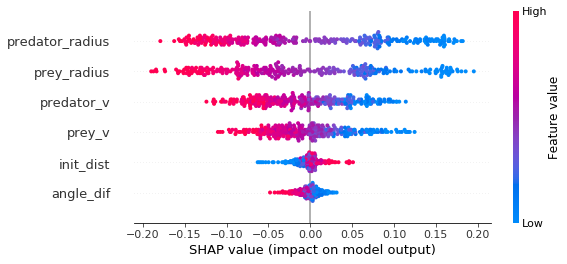

In [32]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_va.iloc[:300])
shap.summary_plot(shap_values[1], X_va.iloc[:300], plot_type='dot')

In [30]:
engineering(X_train)

,predator_radius,prey_radius,predator_v,prey_v,angle_dif,init_dist
23177,34.412293,39.906477,86.881328,282.453496,0.635988,556.092133
99810,10.666808,36.703657,284.367301,136.963388,0.352799,480.769728
860,17.437325,22.785379,226.064428,275.392175,1.044238,605.362259
51130,23.867557,7.008446,339.735010,284.562317,0.434330,676.889903
1140,13.263107,30.479196,279.593249,333.172110,0.589120,736.776959
...,...,...,...,...,...,...
7962,39.183802,28.265448,386.969452,230.967521,0.020022,803.150099
12123,16.539152,7.437079,300.801969,202.099331,0.240450,144.193062
32765,11.851633,17.737822,196.769491,296.994539,0.537162,430.742001
60120,39.649023,39.803169,214.517747,306.107230,0.467971,654.247351


In [36]:
y_train.value_counts(normalize=True)

0.0    0.611805
1.0    0.388195
Name: prey_survived, dtype: float64

In [37]:
y_val.value_counts(normalize=True)

0.0    0.611102
1.0    0.388898
Name: prey_survived, dtype: float64

In [38]:
y_test.value_counts(normalize=True)

0.0    0.614494
1.0    0.385506
Name: prey_survived, dtype: float64